<p style="text-align:center">
    <a href="https://www.ict.mahidol.ac.th/en/" target="_blank">
    <img src="https://www3.ict.mahidol.ac.th/ICTSurveysV2/Content/image/MUICT2.png" width="400" alt="Faculty of ICT">
    </a>
</p>

# Lab09: ML Basics: Unsupervised Learning - Assignment

Clustering is an unsupervised (learning) technique for analysis of data. We will use these techniques for:
- `Part 1 - Get to know data clustering`
- `Part 2 - Data Insights from grouping or group profiling`.

The main focus for this Lab Assignment is:
- `finding a good parameter set` for each model by measuring performance on a range of models. 
- Read through the `Tutorial Notebook` before starting these exercises and questions.


__Instructions:__
1. Append your ID at the end of this jupyter file name. For example, ```ITCS227_Lab0X_Assignment_6788123.ipynb```
2. Complete each task and question in the lab.
3. Once finished, raise your hand to call a TA.
4. The TA will check your work and give you an appropriate score.
5. Submit your IPYNB source code to MyCourses as record-keeping.

```









```
# Load Imports and Library of Helper Functions

- Run this cell to use its functions later. Contains plotting functions.

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import Voronoi, voronoi_plot_2d
import warnings
warnings.simplefilter("ignore", UserWarning)


def one_hot_encode(df, columns_to_encode):
    df_encoded = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for col in columns_to_encode:
        if col in df_encoded.columns: #Check if the column exists.
            one_hot = pd.get_dummies(df_encoded[col], prefix=col)
            df_encoded = pd.concat([df_encoded, one_hot], axis=1)
            df_encoded = df_encoded.drop(col, axis=1) #remove the original column
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df_encoded

def _plot_sihouette_score(silhouette_scores, param_range, param_name):
    plt.figure(figsize=(10, 3))
    plt.plot(param_range, silhouette_scores, marker='o', linestyle='--', color='r')
    plt.title('Silhouette Analysis')
    plt.xlabel(param_name.upper())
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
def _plot_wcss_elbow_method(n_clusters_range, wcss):
    plt.plot(n_clusters_range, wcss, marker='o')
    plt.title('Elbow Method:')
    plt.xlabel('Number of Clusters (n_clusters)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(n_clusters_range)
    plt.grid(True)
    plt.show()
    
def get_centroids_from_clusters(X:np.array, cluster_labels:list):
    centroids = []
    for c_id in np.unique(cluster_labels):
        p = X[cluster_labels == c_id]
        c = p.mean(axis=0)
        centroids += [c]
    return centroids

def _plot_voronoi_2d(point, labels):
    def plot_voronoi_2d( vor, data_points, data_label, plot_title, sub_title):
        voronoi_plot_2d(vor, show_vertices=True, line_alpha=0.5, point_size=15)
        
        plt.plot(data_points[:, 0], data_points[:, 1], "k.", markersize=2, label=data_label)
        plt.ylabel('y')
        plt.xlabel('x')
        plt.title(plot_title, fontsize=10, fontweight='bold')
        plt.gca().text(x=-0.05,y=-0.15, s=sub_title, fontsize=6, fontweight='bold', transform=plt.gca().transAxes)
        
        for region in vor.regions:
            if not -1 in region:
                polygon = [vor.vertices[i] for i in region]
                plt.fill(*zip(*polygon), alpha=0.2)
        
        current_xlim = plt.gca().get_xlim()
        current_ylim = plt.gca().get_ylim()
        x_margin = 0.3 * (current_xlim[1] - current_xlim[0])
        y_margin = 0.3 * (current_ylim[1] - current_ylim[0])
        plt.xlim(current_xlim[0] - x_margin, current_xlim[1] + x_margin)
        plt.ylim(current_ylim[0] - y_margin, current_ylim[1] + y_margin)
                
    centroid_points = get_centroids_from_clusters(points, labels)
    vor = Voronoi(centroid_points) # compute Voronoi tesselation
    
    plot_voronoi_2d( vor, points, 
                    data_label='', 
                    plot_title='Voronoi Cells for Clusters',
                    sub_title='')
    
def _plot_centroid_lines(data, labels):
    centroids = get_centroids_from_clusters(data, labels)
    for cid, centr in enumerate(centroids):
        plt.scatter([centr[0]], [centr[1]], c='red', s=50, marker='x')
        c_data = data[data['Cluster Label']==cid]
        for c in c_data.iterrows():
            plt.plot([c[1][0], centr[0]], [c[1][1], centr[1]], c='k', lw=0.25, ls='dashed', alpha=0.5 )
            
def plot_dendrogram(model, cutpoint_1=7, cutpoint_2=15, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.ylabel("Number of points in node \n(or index of point if no parenthesis).")
    plt.xlabel('Cophenetic distance')
    plt.gca().axvline(cutpoint_1, color='r',ls='--',lw=2, label=f'Arbitrary cut-point {cutpoint_1}')
    plt.gca().axvline(cutpoint_2, color='g',ls='--',lw=0.5, label=f'Arbitrary cut-point {cutpoint_2}')
    plt.legend()
    print('The arbitrary cut-point is used to select the number of desired clusters, based on the Cophenetic distance.')
    print('Note: Cophenetic distance is the cluster separation distance; longer legs indicates greater separation distances.')
    print('      Right-hand numbers with parentheses    - specify how many records are within a cluster / "leg".')
    print('                         without parentheses - specify a cluster with a single record\'s index number.')
    plt.show()


def plotly_map(df, latlng_cols=('lat','lng'), z=None, custom_data_cols=[], custom_text=[], zoom=5, WRITE=False, WRITE_FN=None):
    """ 
    @WRITE_FN - do not include extension - i.e. `.png` or `.html`, as both files will be written.
    Docs:   https://plotly.com/python-api-reference/generated/plotly.express.density_mapbox.html
            https://plotly.com/python/mapbox-density-heatmaps/
    """
    pio.templates.default = 'plotly_white' # 'plotly_dark'
    fig = px.density_mapbox(df, 
                            lat=latlng_cols[0], 
                            lon=latlng_cols[1], 
                            z=z,
                            radius=5,
                            center=dict(lat=13.6, lon=100.4), zoom=zoom,
                            mapbox_style=["open-street-map",'carto-darkmatter'][0],
                            custom_data=custom_data_cols,
                           )

    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    if custom_text:
        fig.update_traces(
            hovertemplate="<br>".join(custom_text)
        )
    fig.show(config={'displayModeBar': False} )
    if WRITE:
        if WRITE_FN != None and isinstance(WRITE_FN, str) and len(WRITE_FN)>4:
            ofn = f'{WRITE_FN}_MapPlot_{TIMESTAMP_FILENAME()}'
            fig.write_image(ofn+'.png')
            fig.write_html(ofn+'.html', full_html=False, include_plotlyjs=False, include_mathjax=False )

def plotly_map_color_points(df, latlng_cols=('lat','lng'), z=None, custom_data_cols=[], custom_text=[], 
                            WRITE=False, WRITE_FN=None, SHOW=False ):
    """
    See - https://plotly.com/python/mapbox-layers/
    """
    fig = px.scatter_mapbox(df, 
                         lat=df[latlng_cols[0]],
                         lon=df[latlng_cols[1]],
                         color=z, # which column to use to set the color of markers
                         #hover_name="country", # column added to hover information
                         # size=markersize, # size of markers
                        center=dict(lat=13.6, lon=100.4), zoom=4,
                        mapbox_style=["open-street-map",'carto-darkmatter'][0],
                        custom_data=custom_data_cols,
                        )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    if custom_text:
        fig.update_traces(
            hovertemplate="<br>".join(custom_text)
        )
    if SHOW:
        fig.show(config={'displayModeBar': False} )
    if WRITE:
        if WRITE_FN != None and isinstance(WRITE_FN, str) and len(WRITE_FN)>4:
            ofn = f'{WRITE_FN}_MapPlot_{TIMESTAMP_FILENAME()}'
            fig.write_image(ofn+'.png')
            fig.write_html(ofn+'.html', full_html=False, include_plotlyjs=False, include_mathjax=False )
    return fig
    
def _plot_scatter_per_cluster(df, labels, 
                              xlabel='capacity (mw)',
                              ylabel='avg. annual output (mwh)',
                              hue='avg. annual output (mwh)'):
    l = 2 if len(np.unique(labels)) % 2==0 else 1
    # Create subplots with two clusters in each row
    fig, axes = plt.subplots(len(np.unique(labels)) // l, l, figsize=(12, 10), sharey=True, sharex=True)
    # Flatten the axes array to iterate through subplots
    axes = axes.ravel()
    
    # Loop through each cluster and plot it
    for cluster_id in np.unique(labels):
        # Filter data for the current cluster
        cluster_data = df[df['Cluster Label']==cluster_id]
        sns.scatterplot(data=cluster_data, x=xlabel, y=ylabel, hue=hue, palette='viridis', ax=axes[cluster_id])
        axes[cluster_id].set_title(f'Cluster {cluster_id}')
        axes[cluster_id].set_xlabel(xlabel.title())
    plt.ylabel(ylabel.title())
    
    # Adjust subplot spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

```












```
# Part 1 - Getting to know Data Clustering



## Task 1: Clustering Blobs
##### Load a dataset and visualize features:
- This time we will use `make_blobs()`, which return datasets that are easy to separate using clustering algorithms, like KMeans.


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs

data, _ = make_blobs(n_samples=300, centers=4, n_features=2, cluster_std=0.90, random_state=0)
data = pd.DataFrame(data)

##### Data Exploration & Visualization steps:

In [40]:
# Display basic information about the dataset
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
 1   1       300 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB
None
                0           1
count  300.000000  300.000000
mean    -0.041539    3.957382
std      1.775345    2.673593
min     -3.920159   -1.597670
25%     -1.561936    1.851250
50%     -0.148559    3.534517
75%      1.379225    6.013277
max      4.128793   10.006668


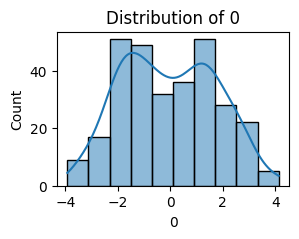

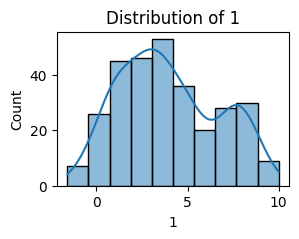

In [41]:
# Visualize the distribution of the first few variables
for column in data.columns[:5]:  # Adjust the range as needed
    plt.figure(figsize=(3, 2))
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

#### Use `sns.scatterplot(...)` to plot the two columns of blobs data:

<Axes: xlabel='0', ylabel='1'>

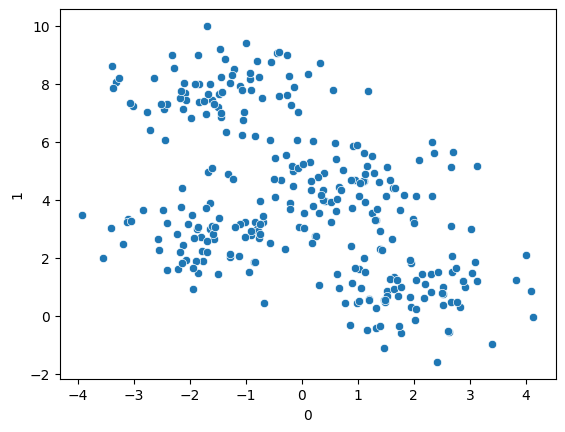

In [42]:
# Insert your code here:
sns.scatterplot(data=data, x =0 , y = 1)


<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
sns.scatterplot(data=data, x=0, y=1)
```

</details>


##### Prepare Data for Clustering (Only `X` data, no `y`)
In unsupervised modelling we generally have no "external" measurement of validity. Therefore we have no way to evaluate the model on external data; therefore no need to split train and test sets.

In [43]:
X = data

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
X = data
```

</details>


#### Choose whether data pre-preprocessing (*numeric feature* `Scaling` or *categorical feature* `Encoding`) is required and apply it to the `X` data:

- Scale the selected data (`X` only) for modelling, encode and handle missing values.

In [44]:
from sklearn.preprocessing import StandardScaler

# X_encoded = one_hot_encode(X, ['col'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Choose a clustering algorithm to `fit( ... )`

* Choose a `model = ... ()` and `model.fit( ... )` on the training data.
* For now, choose a `KMeans(..)` model, with parameter `n_clusters=4`.

In [45]:
from sklearn.cluster import KMeans

# Insert your code here:
model = KMeans(n_clusters=4)
model = model.fit(X_scaled)


<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
model = KMeans(n_clusters=4)
model = model.fit(X_scaled)
```

</details>


#### Get the predicted `cluster labels` from the model and add as a new column in the original dataframe:

In [46]:
labels = model.labels_
print('Unique Labels', np.unique(labels), f'\t DF_n={len(data)}, Cluster_n={len(labels)}' )
data['Cluster Label'] = pd.Series(labels, index=data.index[:len(labels)])

Unique Labels [0 1 2 3] 	 DF_n=300, Cluster_n=300


<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
labels = model.labels_
print('Unique Labels', np.unique(labels), f'\t DF_n={len(data)}, Cluster_n={len(labels)}' )
data['Cluster Label'] = pd.Series(labels, index=df.index[:len(labels)])
```

</details>


#### Use sns.scatterplot adding colors for the `Cluster Label` column:

<Axes: xlabel='0', ylabel='1'>

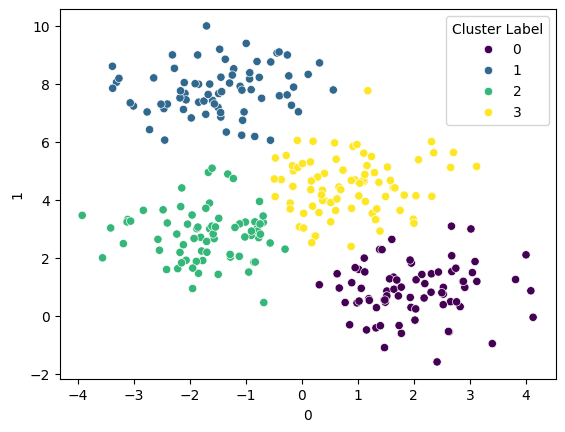

In [47]:
# Insert your code here:
sns.scatterplot(data=data, x=0, y=1, hue='Cluster Label', palette='viridis')


<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
sns.scatterplot(data=data, x=0, y=1, hue='Cluster Label', palette='viridis')
```

</details>


#### Nice! Let's measure the best number of blobs using the `Elbow Method`:
- We created 4 blobs in the dataset, so that's why we picked `n_clusters=4`.
- We can let the data decide for us by measuring the `Within-Cluster Sum of Squares (WCSS)` metric (as part of KMeans).

**Interpretation:** 
- An `inflection point` (or `"elbow"`) is where the rate of decrease in WCSS sharply changes. At that point is the best choice for number of clusters. Below you shold find that the "elbow" is at 4 clusters.
    - `KMeans` has its `model.inertia_` value.
    - `GMM` has its `model.aic` and `model.bic` values, which can be interpreted by the inflection point.

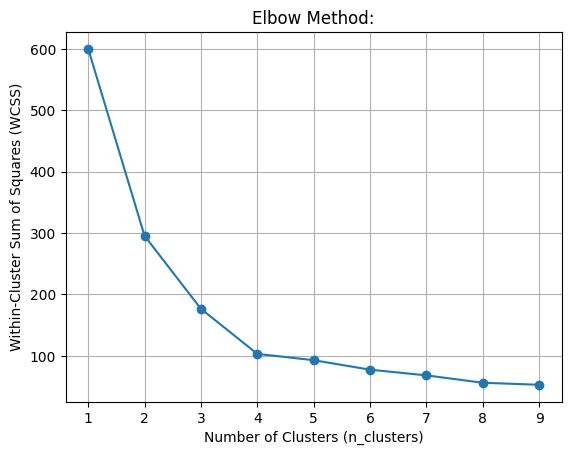

In [48]:
n_clusters_range = range(1,10)
wcss = []
for n_clusters in n_clusters_range:
    model = KMeans(n_clusters=n_clusters)
    model.fit(X_scaled)
    wcss.append(model.inertia_)  # inertia_ is the WCSS
    
_plot_wcss_elbow_method(n_clusters_range, wcss)

## Q: At which number of clusters is the "Elbow" point? Briefly mention how you decided.

Ans: ___4 because it's the pointed that start less decreasing

#### Let's further visualize these clusters:

- Plot the `cluster centroid` (center) and `line` distances plot using code example from the Tutorial.

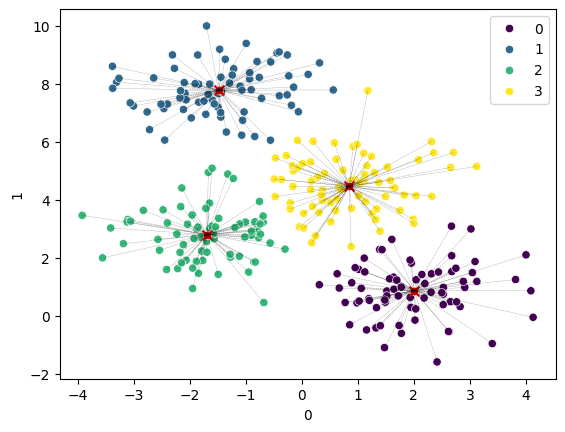

In [49]:
# Insert your code here:
centroid_points = get_centroids_from_clusters(data[[0,1]], labels)
sns.scatterplot(data=data, x=0, y=1, hue='Cluster Label', palette='viridis')
sns.scatterplot(data=pd.DataFrame(centroid_points), x=0, y=1, color='red')
_plot_centroid_lines(data, labels)

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
centroid_points = get_centroids_from_clusters(data[[0,1]], labels)
sns.scatterplot(data=data, x=0, y=1, hue='Cluster Label', palette='viridis')
sns.scatterplot(data=pd.DataFrame(centroid_points), x=0, y=1, color='red')
_plot_centroid_lines(data, labels)
```

</details>


- Plot the `Voronoi Cells Diagram` (spatial-partitioning-diagrams) also can visualize segmentations of clustered groups.

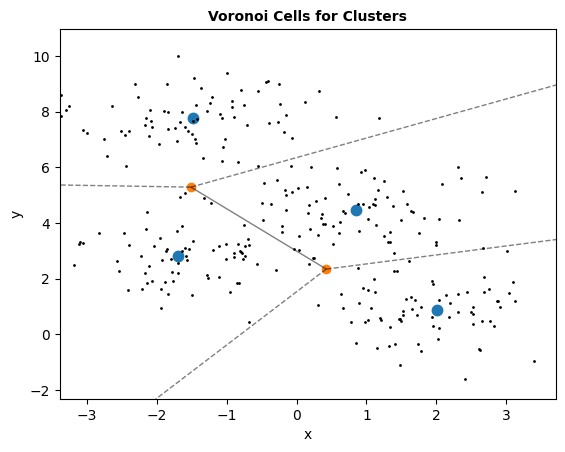

In [50]:
# Insert your code here:
points = data[[0,1]].to_numpy()
_plot_voronoi_2d(points,  labels)

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
points = data[[0,1]].to_numpy()
_plot_voronoi_2d(points,  labels)
```

</details>


```












```
## Task 2: New Blob Dataset:
- Below is a new blob dataset. `How many clusters do you think it should have?`
- We can use clustering metrics to help us decide a cluster grouping that maximises a score, `without having an external ground truth`.

> *Note:*
> - *If we have an external ground truth that is much better, as we can check if a maximised cluster score really is better, rather than just statistically better.*
> - *However, the nature of `unsupervised modelling` is that mostly we do not have this; unless we manually label the data or attach it to an* **`End-To-End ML Application metric`**, such as **quarterly profit**.

<Axes: xlabel='0', ylabel='1'>

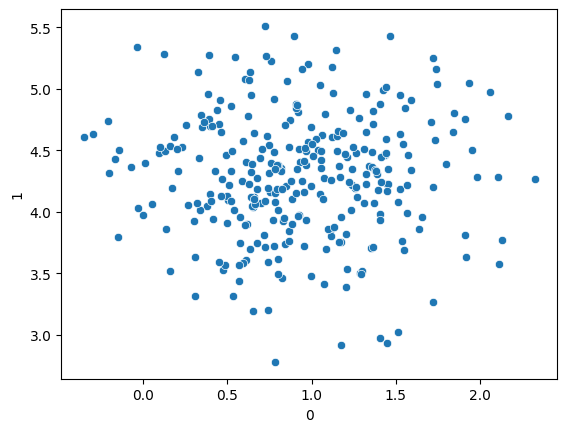

In [51]:
data, _ = make_blobs(n_samples=300, centers=1, n_features=2, cluster_std=0.50, random_state=0)
data = pd.DataFrame(data)
sns.scatterplot(data=data, x=0, y=1)

##### Prepare Data for Clustering (Only `X` data, no `y`)
In unsupervised modelling we generally have no "external" measurement of validity. Therefore we have way to evaluate the model on external data; therefore no need to split train and test sets.

In [52]:
# Insert your code here:
X = data

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
X = data
```

</details>


- Scale the selected data (`X` only) for modelling, encode and handle missing values.

In [53]:
from sklearn.preprocessing import StandardScaler

# X_encoded = one_hot_encode(X, ['col'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

* Choose a `model = ... ()` and `model.fit( ... )` on the training data.

- There are many more Clustering Algorithms, which work well for different types of datasets:
- Take a look at the options here:  https://scikit-learn.org/stable/modules/clustering.html
- Choosing between them for a given dataset is hard, best is to experiment with many models, visualize the results, and try to integrate the clustering into an End-to-End ML application task (to verify each clustering performance).
- [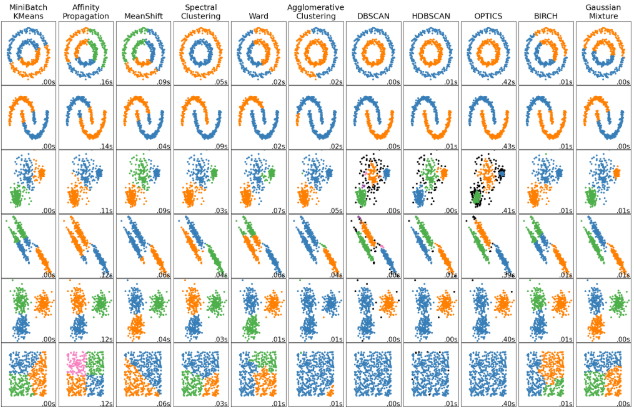](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)


##### This time use the DBScan algorithm:

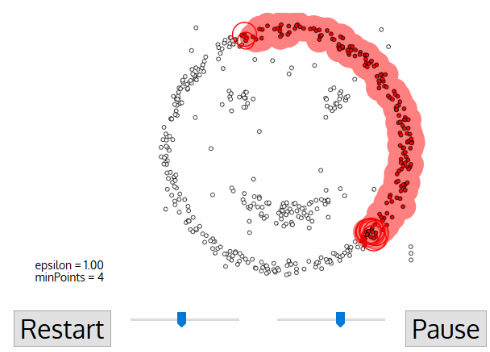

See animated Visualization https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/ 

- Create the DBSCAN model with parameters values for `eps` (float, e.g. 0.4), `min_samples` (int, e.g. 4).
- `fit(...)`
- and assign `labels = ...`

In [54]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.4, min_samples=4)
model = model.fit(X_scaled)
labels = model.labels_


<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
model = DBSCAN(eps=0.4, min_samples=4)
model = model.fit(X_scaled)
labels = model.labels_
```

</details>


Unique Labels [-1  0] 	 DF_n=300, Cluster_n=300


<Axes: xlabel='0', ylabel='1'>

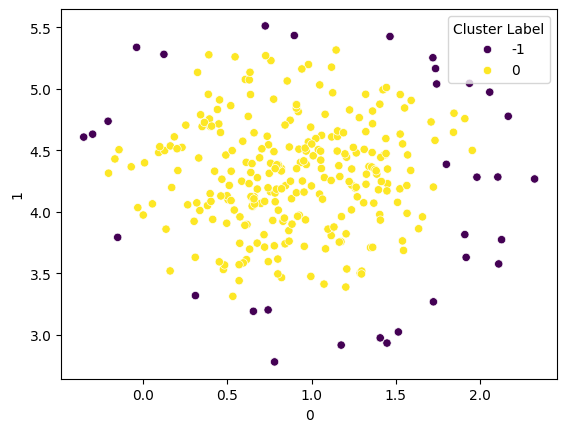

In [55]:
print('Unique Labels', np.unique(labels), f'\t DF_n={len(data)}, Cluster_n={len(labels)}' )
data['Cluster Label'] = pd.Series(labels, index=data.index[:len(labels)])
sns.scatterplot(data=data, x=0, y=1, hue='Cluster Label', palette='viridis')

#### Let's Measure the Model's Clustering Silhouette Score
- Silhouette Score measures how similar each point is to its own cluster compared to other clusters.
- `A higher average score indicates well-defined clusters.`

##### Silhouette Score in more Detail:

>- `Combines intra-cluster (cohesion) distance and inter-cluster (separation) distances` and is normalized by number of clusters.
>- Average dsitance between a point and all other points in the cluster.
>- Score value between -1 to 1.
>    - High value (1) - indicates well-clusetered and far from neighbouring clusters.
>    - Zero (0) - indicates points are on the decision boundary between clusters.
>    - Low value (-1) - indicates points are in overlapping clusters (may be wrongly assigned).
>- Assumes spherically-shaped clusters.
>- Advantages:
>    - The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
>    - The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
>- Drawbacks:
>    - The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.
>- Reference:
>    - Peter J. Rousseeuw (1987). “Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis”. Computational and Applied Mathematics 20: 53-65.

##### Continued:

In [56]:
from sklearn.metrics import silhouette_score

silhouette_score(X_scaled, labels)

0.3634237357397004

#### Parameter Search & Silhouette Score:

- Using a hyperparameter grid search, we can explore the `silhouette` metric score for different model parameter values, and choose the best performing parameter configuration:

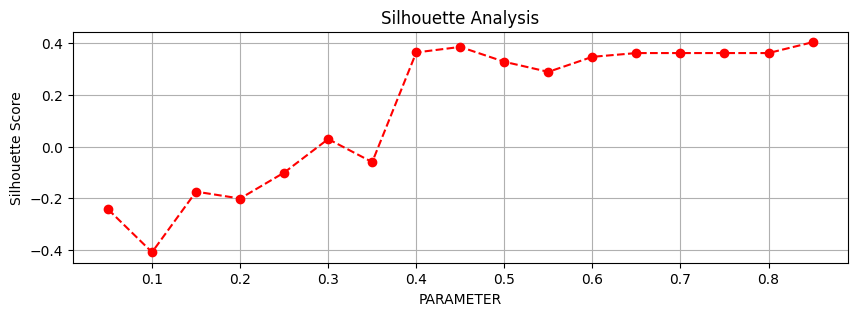

,Param,Silhouette Score
16,0.85,0.402951
8,0.45,0.384807
7,0.40,0.363424
12,0.65,0.361091
13,0.70,0.361091
14,0.75,0.361091
15,0.80,0.361091
11,0.60,0.346539
9,0.50,0.327421
10,0.55,0.288445


Best Parameter is:  0.8500000000000001


0.8500000000000001

In [57]:
# Insert your code here:
silhouette_scores = []
eps_range = np.arange(0.05,2,0.05)
for _eps in eps_range:
    model = DBSCAN(eps=_eps, min_samples=4)
    model = model.fit(X_scaled)
    labels = model.labels_
    if len(np.unique(labels))>1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = float('nan')
    silhouette_scores += [ score ]


def get_best( param_range, silhouette_scores ):
    dfr = pd.DataFrame([param_range, silhouette_scores]).T.rename(columns={0:'Param', 1:'Silhouette Score'}).sort_values(by=['Silhouette Score'], ascending=False).dropna()
    display(dfr)
    best =  dfr.iloc[0].Param
    print('Best Parameter is: ',best)
    return best

_plot_sihouette_score(silhouette_scores, param_range=eps_range, param_name='Parameter')
best = get_best( eps_range, silhouette_scores )
best

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
silhouette_scores = []
eps_range = np.arange(0.05,2,0.05)
for _eps in eps_range:
    model = DBSCAN(eps=_eps, min_samples=4)
    model = model.fit(X_scaled)
    labels = model.labels_
    if len(np.unique(labels))>1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = float('nan')
    silhouette_scores += [ score ]


def get_best( param_range, silhouette_scores ):
    dfr = pd.DataFrame([param_range, silhouette_scores]).T.rename(columns={0:'Param', 1:'Silhouette Score'}).sort_values(by=['Silhouette Score'], ascending=False).dropna()
    display(dfr)
    best =  dfr.iloc[0].Param
    print('Best Parameter is: ',best)
    return best

_plot_sihouette_score(silhouette_scores, param_range=eps_range, param_name='Parameter')
best = get_best( eps_range, silhouette_scores )
best
```

</details>


Using Best EPS Parameter: 0.8500000000000001
Unique Labels [0 1] 	 DF_n=300, Cluster_n=300


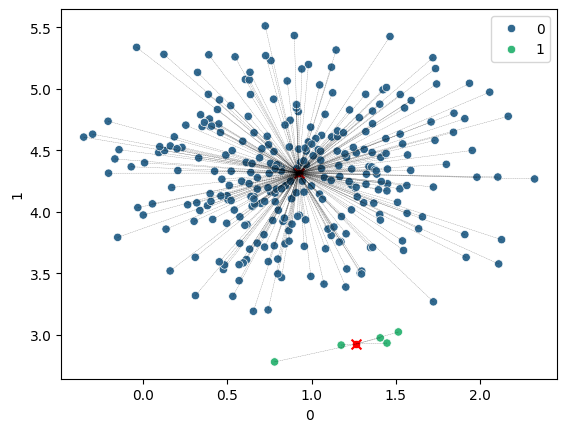

In [58]:
print('Using Best EPS Parameter:', best)
model = DBSCAN(eps=best, min_samples=4)
model = model.fit(X_scaled)
labels = model.labels_
print('Unique Labels', np.unique(labels), f'\t DF_n={len(data)}, Cluster_n={len(labels)}' )
data['Cluster Label'] = pd.Series(labels, index=data.index[:len(labels)])

centroid_points = get_centroids_from_clusters(data[[0,1]], labels)
sns.scatterplot(data=data, x=0, y=1, hue='Cluster Label', palette='viridis')
sns.scatterplot(data=pd.DataFrame(centroid_points), x=0, y=1, color='red')
_plot_centroid_lines(data, labels)

### Q: What was the best `EPS` parameter for this dataset?
Ans: 0.85

### Q: How many `unique cluster labels` did DBScan give you for this dataset with the "best" `EPS` parameter?
Ans: 2

```













```
# Part 2 - Real Data Insights from grouping or group profiling - Mekong Region Hydropower Dams:

In data analysis processes, sometimes it can be informative to "group" related instances using a `cluster analysis`. `Group-by` is the immediate choice for this; however, clustering differs by `measuring similarity` between instances, and not only including `specifically matching conditions`. 
- Using a clustering model to group a dataset of animals might reveal that `four legs, whiskers and a tail` creates a group; which we will then have to give a name (e.g. cats and dogs).
- Using a `group-by` statement (such as in SQL or Pandas) we have to `decide and know explicitly the relationship between those features` (e.g. `(legs==4, whiskers=True, tail==True)`).
- Clustering can find this kind of grouping-arrangement for us.

In this part we will look at two tasks to gain insights into Hydropowered Dam Powerstations in the Mekong Region:
- Geographical Clustering of Powerstations
- Powerstation Performance Clustering 

##### Load the dataset

The dataset is **Mekong Regional Hydropower Dams 2020** - **Published by: [Open Development Mekong](https://data.opendevelopmentmekong.net/en/organization/mekong-organization)** in 2020, it contains known hydropower dams in the Mekong region (with a status as  **operational, planned, postponed, potential or under construction**). 

* This dataset was compiled from Greater Mekong Dams Observatory, the Consultative Group on International Agricultural Research (CGIAR) Challenge Program on Water and Food - Mekong (for Mekong basin dams only), Mekong Infrastructure Tracker, USAID Mekong Safeguards Project, and other publicly available sources.
    - **Dataset Source:** - https://data.opendevelopmentmekong.net/en/dataset/mekong-regional-hydropower-dams-2020
    - **Dataset License: - CC BY-SA 4.0** *(This work and any original materials produced and published by Open Development Mekong herein are licensed under a CC BY-SA 4.0.)*

In [59]:
df = pd.read_csv('files/Mekong Regional Hydropower Dams 2020_OpenDevMekong.csv')

##### Data Exploration:

In [60]:
display( df.sample(2) )
display( df.info() )
display( df.describe() )

,_id,wkb_geometry,country,project name,type,status,capacity (mw),year of completion,country list of sponsor/developer,sponsor/developer company,...,province/state,district,tributary,latitude,longitude,proximity,avg. annual output (mwh),data source,announcement/more information,link
115,116,0101000020E6100000D234289A07F559401D3BA8C475DC...,Vietnam,Ban Chat,Hydro,Operational,220.0,2013.0,NaN,NaN,...,NaN,NaN,NaN,21.861172,103.828589,NaN,NaN,Open Development Vietnam,NaN,https://data.opendevelopmentmekong.net/dataset...
273,274,0101000020E6100000D3FA5B02F0FF59401D1F2DCE18DE...,Vietnam,Khao Mang Thuong,Hydro,Operational,24.5,2015.0,NaN,NaN,...,NaN,NaN,NaN,21.867566,103.999024,NaN,NaN,Open Development Vietnam,NaN,https://data.opendevelopmentmekong.net/dataset...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   _id                                   551 non-null    int64  
 1   wkb_geometry                          551 non-null    object 
 2   country                               551 non-null    object 
 3   project name                          551 non-null    object 
 4   type                                  551 non-null    object 
 5   status                                551 non-null    object 
 6   capacity (mw)                         546 non-null    float64
 7   year of completion                    362 non-null    float64
 8   country list of sponsor/developer     321 non-null    object 
 9   sponsor/developer company             323 non-null    object 
 10  country list of lender/financier      42 non-null     object 
 11  lender/financier co

None

,_id,capacity (mw),year of completion,latitude,longitude,avg. annual output (mwh)
count,551.000000,546.000000,362.000000,551.000000,551.000000,7.400000e+01
mean,276.000000,175.867381,2011.668508,17.582339,103.421405,1.919158e+05
std,159.204271,636.759253,10.801434,4.415096,4.214097,4.932527e+05
min,1.000000,0.020000,1954.000000,6.141788,92.652188,1.000000e+04
25%,138.500000,10.000000,2010.000000,13.523625,100.176077,4.000000e+04
50%,276.000000,26.500000,2014.000000,17.916800,104.162500,6.650000e+04
75%,413.500000,94.500000,2018.000000,21.599484,107.154900,1.127175e+05
max,551.000000,7000.000000,2032.000000,27.525940,108.939722,3.680000e+06


##### Visualize Hydropowered Dams Dataset:
For this dataset, we will use Plotly interactive mapping, as it let's us visualize and explore the dataset.
- We will use the `plotly_map(...) - helper function`, and a one or two others from the top of the file.

In [61]:
plotly_map(df[df['status']=='Operational'], 
           latlng_cols=('latitude','longitude'), 
           z='capacity (mw)',
           zoom=3,
           custom_data_cols=['project name',
                             'country',
                             'capacity (mw)',
                             '_id'
                           ], 
           custom_text=['Project: %{customdata[0]}',
                        'Country: %{customdata[1]}',
                        'Capacity (mw): %{customdata[2]}',
                        'ID: %{customdata[3]}',
                            ])

C:\Users\gifly\AppData\Local\Temp\ipykernel_176\3000242636.py:127: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



```

















```
## Task 1: Geographical Clustering: by Lat / Long: Model: DBScan:

Use case:
- Identifying clusters of projects based on their geographical proximity (latitude, longitude).
- Detecting regional patterns in project development.
- Analyzing the spatial distribution of projects within countries or provinces.


Clustering Variables:
- `'latitude','longitude'`

Insights:
- Areas with high project concentration.
- Potential infrastructure or resource hubs.
- Estimate regional resource allocation and planning.

In [62]:
X = df[['latitude','longitude']].dropna().to_numpy()

- As `Lat` and `Long` are in the `same unit scale`, it is `optional` whether to re-scale the features.

In [63]:
from sklearn.preprocessing import StandardScaler

# X_encoded = one_hot_encode(X, ['col'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


* We will use `DBSCAN` clustering algorithm here, as it can handle irregular shapes which can be common in geographical clustering. (Although GMM with large `n_components` might be a good choice too.)
* We can modify the `eps` parameter to change the number of clusters.

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

#### Parameter Search on DBScan with Silhouette Score:

- Using a hyperparameter grid search, explore the `silhouette` metric score for different model parameter values, and choose the best performing parameter configuration:

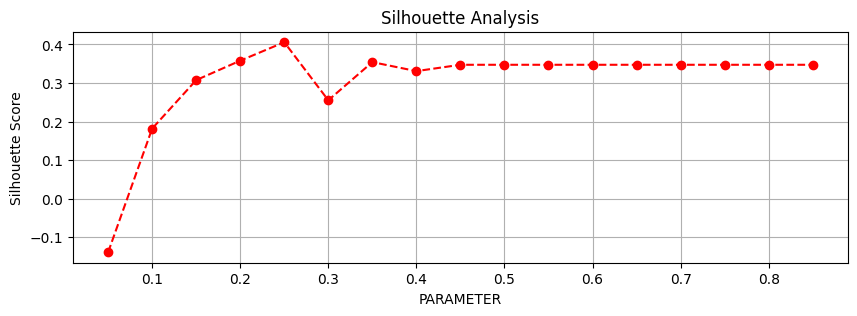

,Param,Silhouette Score
4,0.25,0.405897
3,0.20,0.358037
6,0.35,0.354298
8,0.45,0.347389
10,0.55,0.347389
15,0.80,0.347389
14,0.75,0.347389
13,0.70,0.347389
12,0.65,0.347389
11,0.60,0.347389


Best Parameter is:  0.25


0.25

In [64]:
# Insert your code here:
silhouette_scores = []
eps_range = np.arange(0.05,2,0.05)
for _eps in eps_range:
    model = DBSCAN(eps=_eps, min_samples=4)
    model = model.fit(X_scaled)
    labels = model.labels_
    if len(np.unique(labels))>1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = float('nan')
    silhouette_scores += [ score ]


def get_best( param_range, silhouette_scores ):
    dfr = pd.DataFrame([param_range, silhouette_scores]).T.rename(columns={0:'Param', 1:'Silhouette Score'}).sort_values(by=['Silhouette Score'], ascending=False).dropna()
    display(dfr)
    best =  dfr.iloc[0].Param
    print('Best Parameter is: ',best)
    return best

_plot_sihouette_score(silhouette_scores, param_range=eps_range, param_name='Parameter')
best = get_best( eps_range, silhouette_scores )
best


<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
silhouette_scores = []
eps_range = np.arange(0.05,2,0.05)
for _eps in eps_range:
    model = DBSCAN(eps=_eps, min_samples=4)
    model = model.fit(X_scaled)
    labels = model.labels_
    if len(np.unique(labels))>1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = float('nan')
    silhouette_scores += [ score ]


def get_best( param_range, silhouette_scores ):
    dfr = pd.DataFrame([param_range, silhouette_scores]).T.rename(columns={0:'Param', 1:'Silhouette Score'}).sort_values(by=['Silhouette Score'], ascending=False).dropna()
    display(dfr)
    best =  dfr.iloc[0].Param
    print('Best Parameter is: ',best)
    return best

_plot_sihouette_score(silhouette_scores, param_range=eps_range, param_name='Parameter')
best = get_best( eps_range, silhouette_scores )
best
```

</details>


### Q: What was the best `EPS` parameter for this dataset?
Ans: 0.25

In [65]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=best, min_samples=4)
model = model.fit(X_scaled)
labels = model.labels_

In [66]:
print('Unique Labels', np.unique(labels), f'\t DF_n={len(df)}, Cluster_n={len(labels)}' )
df['Cluster Label'] = pd.Series(labels, index=df.index[:len(labels)])

Unique Labels [-1  0  1  2  3  4  5  6  7] 	 DF_n=551, Cluster_n=551


### Q: How many `unique cluster labels` did DBScan give you for this dataset with the "best" `EPS` parameter?
Ans: 9

In [67]:
plotly_map_color_points(df[df['status']=='Operational'].fillna(0), 
           latlng_cols=('latitude','longitude'), 
           z='Cluster Label',
           custom_data_cols=['project name',
                             'country',
                             'status',
                             'capacity (mw)',
                             'avg. annual output (mwh)',
                             'Cluster Label'
                           ], 
           custom_text=['Project: %{customdata[0]}',
                        'Country: %{customdata[1]}',
                        'Status: %{customdata[2]}',
                        'Capacity (mw): %{customdata[3]}',
                        'Avg.Output/yr (mwh): %{customdata[4]}',
                        'Cluster: %{customdata[5]}',
                            ])


C:\Users\gifly\AppData\Local\Temp\ipykernel_176\3000242636.py:154: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



#### Visualize the clusters individually, according to their Lat / Lng positions.

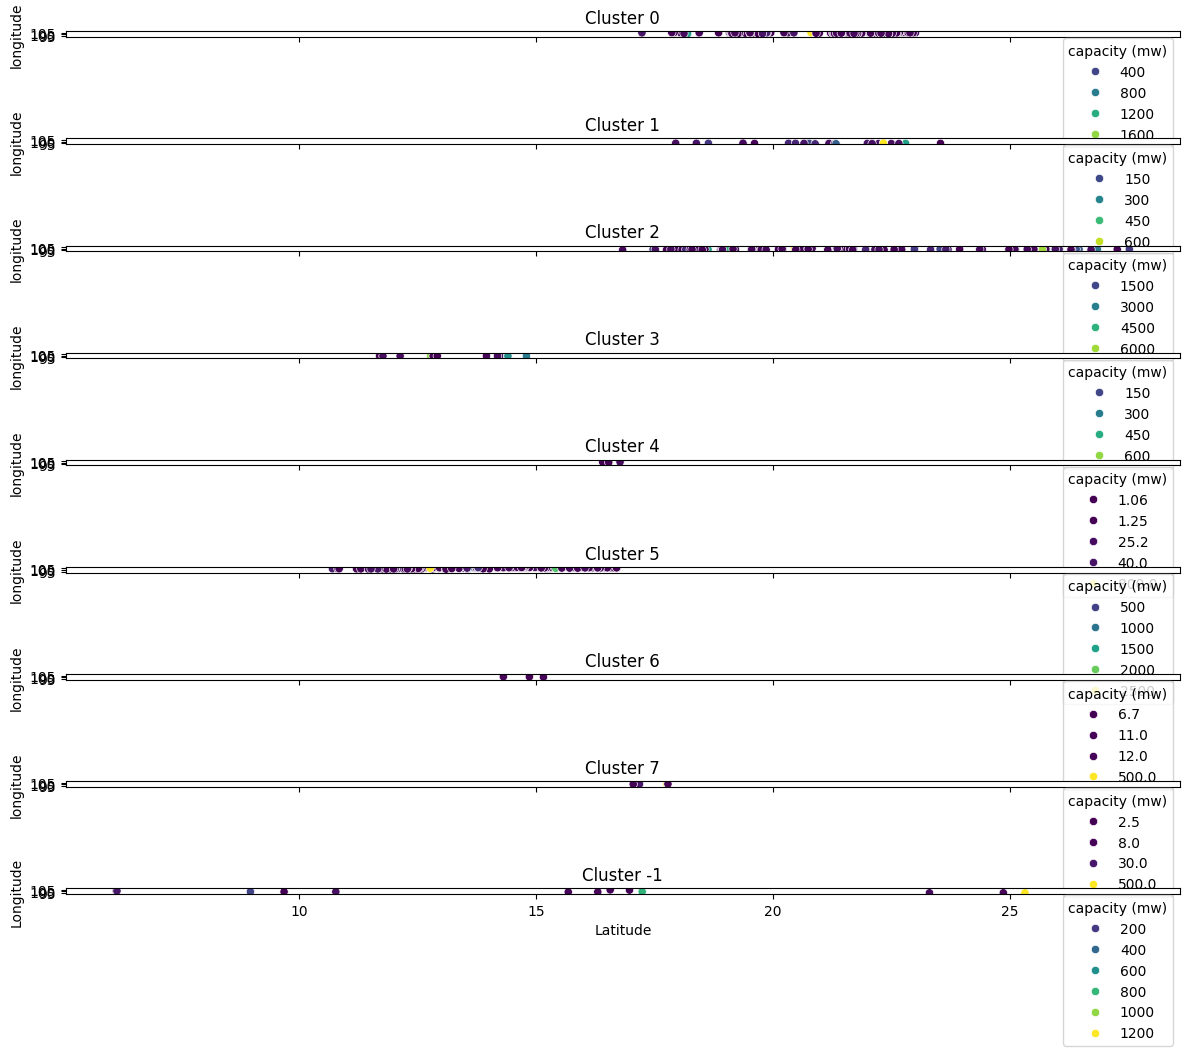

In [68]:
_plot_scatter_per_cluster(df, labels, 
                              xlabel='latitude',
                              ylabel='longitude',
                              hue='capacity (mw)')

```




















```
## Task 2: Project Performance Clustering: by Powerstation Mega-Watt Capacity & Annual Output: Model: KMeans or GMM:

Use Case:
- Group projects based on their performance metrics (capacity, annual output).
- Identify high-performing or underperforming projects.
- Begin to uncover factors that might contribute to project success.

Clustering Variables:
- `capacity (mw)`, `avg. annual output (mwh)`

Insights:
- Insights into the efficiency of different project types or locations.
- Identify projects needing improvement.


In [69]:
X = df[['capacity (mw)','avg. annual output (mwh)']].fillna(0)#.to_numpy()

- Scale the selected data (`X` only) for modelling.

In [70]:
from sklearn.preprocessing import StandardScaler

# X_encoded = one_hot_encode(X, ['col'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Q: Why is it necessary to `scale the numeric features` on this dataset?
Ans: When the numeric features are similar its lead to minimum error and performance better

- Model the data using the Soft-Clustering algorithm GMM Gaussian Mixture Model.

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

#### Parameter Search on GMM Gaussian Mixture Model with Silhouette Score:

- Using a hyperparameter grid search, we can explore the `silhouette` metric score for different model parameter values, and choose the best performing parameter configuration:

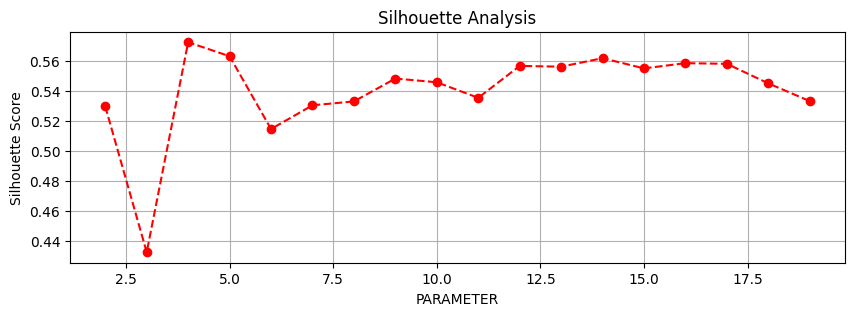

,Param,Silhouette Score
3,4.0,0.572401
4,5.0,0.563074
8,9.0,0.548208
7,8.0,0.532990
6,7.0,0.530423
1,2.0,0.529691
5,6.0,0.514629
2,3.0,0.432635


Best Parameter is:  4.0


4.0

In [71]:
from sklearn.mixture import GaussianMixture
# Insert your code here:
silhouette_scores = []
n_components_range = np.arange(1,20,1)
for n_components in n_components_range:
    model = GaussianMixture(n_components=n_components, random_state=0)
    model = model.fit(X_scaled)
    labels = model.predict(X_scaled)
    if len(np.unique(labels))>1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = float('nan')
    silhouette_scores += [ score ]

def get_best( param_range, silhouette_scores ):
    dfr = pd.DataFrame([n_clusters_range, silhouette_scores]).T.rename(columns={0:'Param', 1:'Silhouette Score'}).sort_values(by=['Silhouette Score'], ascending=False).dropna()
    display(dfr)
    best =  dfr.iloc[0].Param
    print('Best Parameter is: ',best)
    return best

_plot_sihouette_score(silhouette_scores, param_range=n_components_range, param_name='Parameter')
best = get_best( n_components_range, silhouette_scores )
best


<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
silhouette_scores = []
n_components_range = np.arange(1,20,1)
for n_components in n_components_range:
    model = GaussianMixture(n_components=n_components, random_state=0)
    model = model.fit(X_scaled)
    labels = model.predict(X_scaled)
    if len(np.unique(labels))>1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = float('nan')
    silhouette_scores += [ score ]

def get_best( param_range, silhouette_scores ):
    dfr = pd.DataFrame([n_clusters_range, silhouette_scores]).T.rename(columns={0:'Param', 1:'Silhouette Score'}).sort_values(by=['Silhouette Score'], ascending=False).dropna()
    display(dfr)
    best =  dfr.iloc[0].Param
    print('Best Parameter is: ',best)
    return best

_plot_sihouette_score(silhouette_scores, param_range=n_components_range, param_name='Parameter')
best = get_best( n_components_range, silhouette_scores )
best
```

</details>


### Q: What was the best `EPS` parameter for this dataset?
Ans: 4.0

In [72]:
model = GaussianMixture(n_components=int(best))
model.fit(X_scaled)
labels = model.predict(X_scaled)
print('Unique Labels', np.unique(labels), f'\t DF_n={len(df)}, Cluster_n={len(labels)}' )
df['Cluster Label'] = pd.Series(labels, index=df.index[:len(labels)])

Unique Labels [0 1 2 3] 	 DF_n=551, Cluster_n=551


### Q: How many `unique cluster labels` did DBScan give you for this dataset with the "best" `EPS` parameter?
Ans: 4 clusters

- Plot the clusters on the map:

In [73]:
plotly_map_color_points(df\
                        [(df['avg. annual output (mwh)']>0)]
                        .fillna(0), 
           latlng_cols=('latitude','longitude'), 
           z='Cluster Label',
           custom_data_cols=['project name',
                             'country',
                             'status',
                             'capacity (mw)',
                             'avg. annual output (mwh)',
                             'Cluster Label'
                           ], 
           custom_text=['Project: %{customdata[0]}',
                        'Country: %{customdata[1]}',
                        'Status: %{customdata[2]}',
                        'Capacity (mw): %{customdata[3]}',
                        'Avg.Output/yr (mwh): %{customdata[4]}',
                        'Cluster: %{customdata[5]}',
                            ])


C:\Users\gifly\AppData\Local\Temp\ipykernel_176\3000242636.py:154: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



- With Performance data such as Power Capacity (or recency, frequency and monetary factors in financial applications) it can be helpful to visually each cluster to see how each performance grouping is separated.
    - For example, a `high efficiency cluster` and a `low to medium efficiency cluster`.

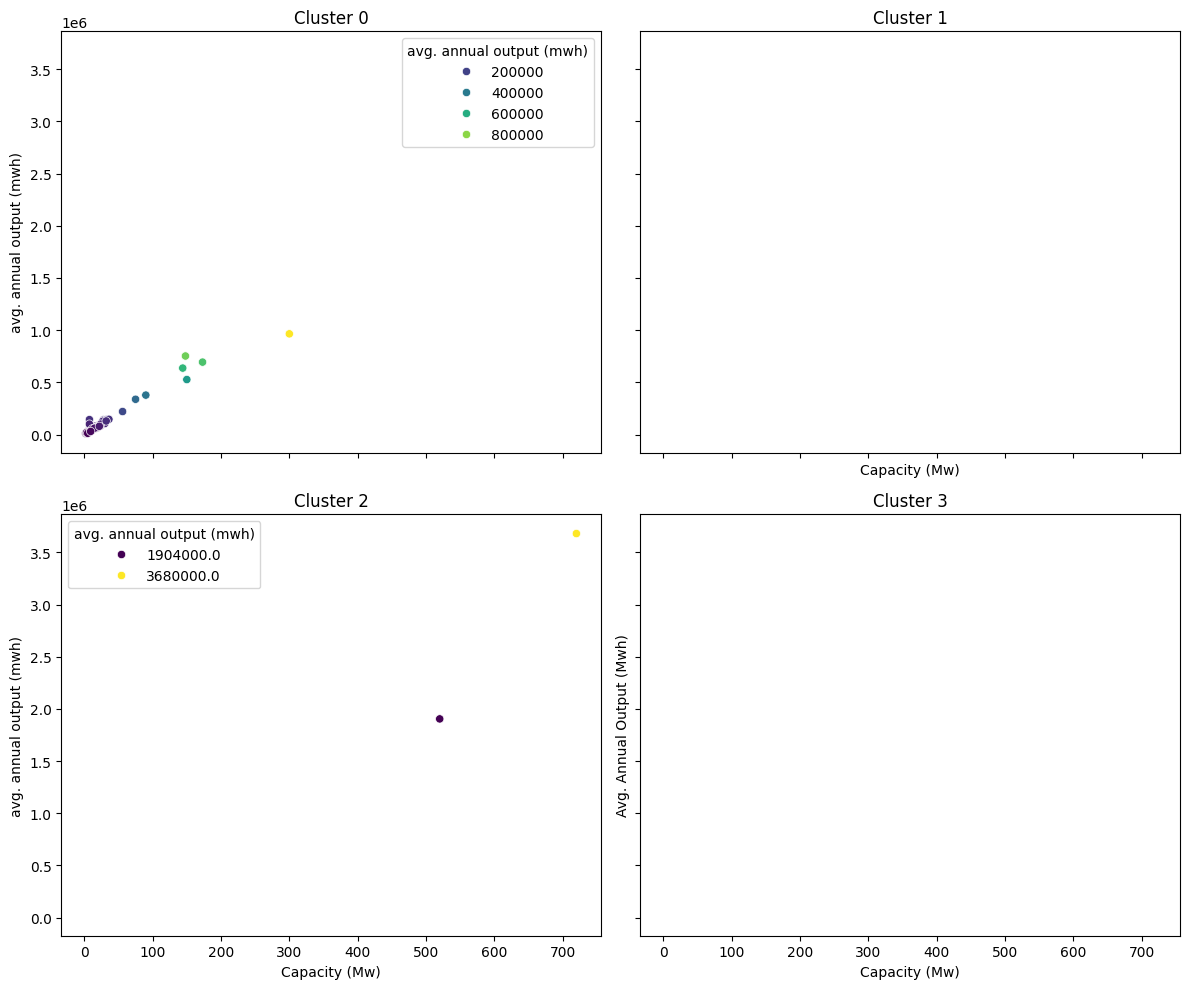

In [74]:
_plot_scatter_per_cluster(df, labels, 
                              xlabel='capacity (mw)',
                              ylabel='avg. annual output (mwh)',
                              hue='avg. annual output (mwh)')

### Q: Take look at each cluster plot (`Capacity (Mw)` by `Avg. Output (MwH)`). Is one cluster more clearly `higher performing` or `lower performing`? Which cluster number?
Ans: Cluster 2 has higher performing

```






```
<p style="text-align:center;">That's it! Congratulations! <br> 
    Now, call an LA to check your solution. Then, upload your code on MyCourses.</p>